<a href="https://colab.research.google.com/github/masudul-islam-asif/Air-Quality-Index-dhaka/blob/main/Copy_of_Dhaka_Air_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Arima and SARIMAX model

In [ ]:
# For data reading | manipulation :
import pandas as pd 

# For reading the array :
import numpy as np

# For visualize the data and plottting patameters :
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns

# To suppress warnings :
from warnings import filterwarnings
filterwarnings('ignore')

# Import train-test split :
from sklearn.model_selection import train_test_split

# Import 'stats' libraries for modeling :
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import OLS

# To scaled the data :
from sklearn.preprocessing import StandardScaler

# To check the accuracy of model :
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Import Statsmodels :
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Read the data :
AQI_Dhaka_city_hour = pd.read_csv('Dhaka Air Quality (2016-2022).csv')


# Print the first five observations to see the data structure :
AQI_Dhaka_city_hour.head()

,Date,Hour,NowCastConc,RawConc,AQI,AQICategory,QCName
0,1/3/2016 3:00,3.0,251.4,289.0,302.0,Hazardous,Valid
1,1/3/2016 4:00,4.0,246.0,240.0,296.0,Very Unhealthy,Valid
2,1/3/2016 5:00,5.0,264.0,290.0,314.0,Hazardous,Valid
3,1/3/2016 6:00,6.0,256.8,245.0,307.0,Hazardous,Valid
4,1/3/2016 7:00,7.0,238.2,205.0,288.0,Very Unhealthy,Valid


In [ ]:
# Checking shape and data types of the data :

AQI_Dhaka_city_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51916 entries, 0 to 51915
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         51913 non-null  object 
 1   Hour         51913 non-null  float64
 2   NowCastConc  51913 non-null  float64
 3   RawConc      51913 non-null  float64
 4   AQI          51913 non-null  float64
 5   AQICategory  51497 non-null  object 
 6   QCName       51913 non-null  object 
dtypes: float64(4), object(3)
memory usage: 2.8+ MB


In [ ]:
# Summary Statistics of the numeric data :

AQI_Dhaka_city_hour.describe()

,Hour,NowCastConc,RawConc,AQI
count,51913.000000,51913.000000,51913.000000,51913.00000
mean,11.496754,79.415534,75.753087,143.92892
std,6.922843,121.568856,149.881010,124.94854
min,0.000000,-999.000000,-999.000000,-999.00000
25%,5.000000,33.000000,31.000000,95.00000
50%,11.000000,61.600000,60.000000,154.00000
75%,17.000000,124.200000,123.000000,186.00000
max,23.000000,844.900000,985.000000,728.00000


In [ ]:
# Checking for the missing values and its precentage :

values = AQI_Dhaka_city_hour.isnull().sum()
percentage = 100*AQI_Dhaka_city_hour.isnull().sum()/len(AQI_Dhaka_city_hour)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('OrRd')

,No of missing values,Percent of missing values
AQICategory,419,0.810000
Date,3,0.010000
Hour,3,0.010000
NowCastConc,3,0.010000
RawConc,3,0.010000
AQI,3,0.010000
QCName,3,0.010000


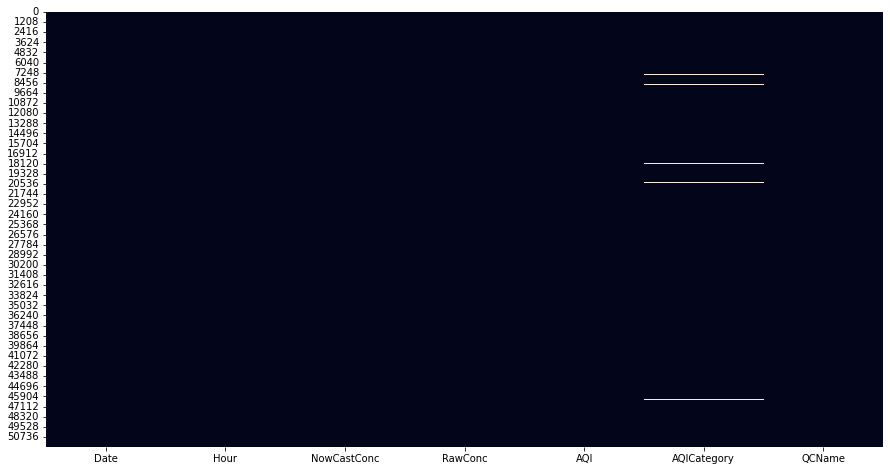

In [ ]:
# Check the missing values with heatmap :

sns.heatmap(AQI_Dhaka_city_hour.isnull(), cbar=False)
plt.show()

In [ ]:
AQI_Dhaka_city_hour.groupby(['Date','Hour'])['AQI'].mean()

Date            Hour
1/1/2017 0:00   0.0     339.0
1/1/2017 10:00  10.0    310.0
1/1/2017 11:00  11.0    284.0
1/1/2017 12:00  12.0    268.0
1/1/2017 13:00  13.0    213.0
                        ...  
9/9/2021 5:00   5.0     177.0
9/9/2021 6:00   6.0     172.0
9/9/2021 7:00   7.0     168.0
9/9/2021 8:00   8.0     164.0
9/9/2021 9:00   9.0     165.0
Name: AQI, Length: 51909, dtype: float64

In [ ]:
# Converting Datetime variable into datetime data type :

AQI_Dhaka_city_hour['Date'] = AQI_Dhaka_city_hour['Date'].apply(pd.to_datetime)

In [ ]:
# Check whether it is converted or not :

AQI_Dhaka_city_hour.dtypes

Date           datetime64[ns]
Hour                  float64
NowCastConc           float64
RawConc               float64
AQI                   float64
AQICategory            object
QCName                 object
dtype: object

In [ ]:
# Impute the missing values by grouping city with and average of 5 days:

data_fill = AQI_Dhaka_city_hour.iloc[:, :15].fillna(AQI_Dhaka_city_hour.iloc[:, :15].groupby(['Hour', pd.Grouper(key='Date', freq='5D')]).transform('mean'))

In [ ]:
# After inputing missing values by day checking for the missing values :

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Purples')

,No of missing values,Percent of missing values
AQICategory,419,0.810000
Date,3,0.010000
Hour,3,0.010000
NowCastConc,3,0.010000
RawConc,3,0.010000
AQI,3,0.010000
QCName,3,0.010000


In [ ]:
# Impute the missing values by grouping city and month :

data_fill = data_fill.fillna(data_fill.groupby(['Hour', pd.Grouper(key='Date', freq='M')]).transform('mean'))

In [ ]:
# After inputing missing values by month check for the missing values :

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Blues')

,No of missing values,Percent of missing values
AQICategory,419,0.810000
Date,3,0.010000
Hour,3,0.010000
NowCastConc,3,0.010000
RawConc,3,0.010000
AQI,3,0.010000
QCName,3,0.010000


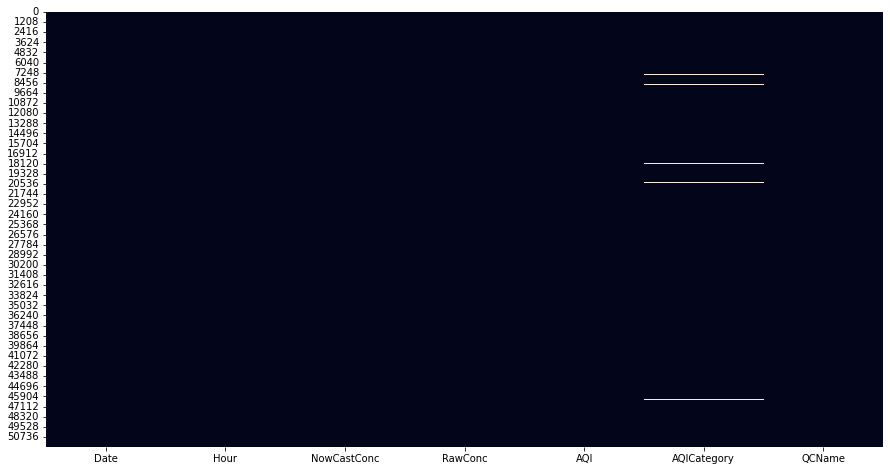

In [ ]:
sns.heatmap(data_fill.isnull(), cbar=False)
plt.show()

In [ ]:
# Imputing missing values by beckward fill :

data_fill = data_fill.fillna(method = 'bfill',axis=0)

In [ ]:
# Still data is missing in the columns, hence using forward fill to impute this :

data_fill = data_fill.fillna(method = 'ffill',axis=0)

In [ ]:
# After inputing missing values by bfill abd ffill:

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Blues')

,No of missing values,Percent of missing values


In [ ]:
# After imputing missing values, check summary statistics of the data :

data_fill.describe()

,Hour,NowCastConc,RawConc,AQI
count,51916.000000,51916.000000,51916.000000,51916.000000
mean,11.496148,79.417781,75.756106,143.931177
std,6.923103,121.565703,149.877205,124.945283
min,0.000000,-999.000000,-999.000000,-999.000000
25%,5.000000,33.000000,31.000000,95.000000
50%,11.000000,61.600000,60.000000,154.000000
75%,17.000000,124.200000,123.000000,186.000000
max,23.000000,844.900000,985.000000,728.000000


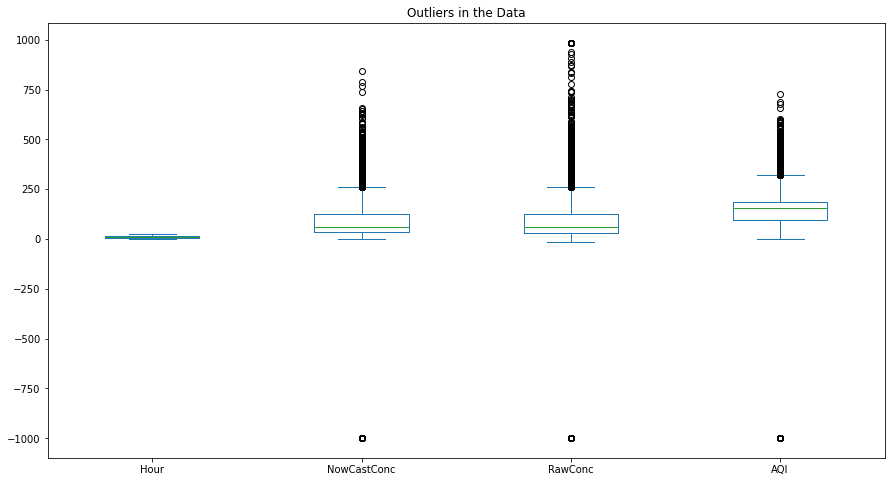

<Figure size 1080x576 with 0 Axes>

In [ ]:
# Checking for outliers :

data_fill.plot(kind='box')
plt.title("Outliers in the Data")
plt.show()
plt.savefig('Outliers.png', dpi=300, bbox_inches='tight')

In [ ]:
# In this we are not concidering the AQI_Bucket column, because it is not nessasary for our analysis.
# Here, we do analysis on all over Dhaka, so Aggregating the data into month wise and creating the new dataframe.

AQI_df = data_fill.groupby(['Hour', (data_fill.Date.dt.strftime('%Y-%m'))]).mean()

# Reset index :
AQI_df = AQI_df.reset_index()

# Check the First 5 observation :
AQI_df.head()

,Hour,Date,NowCastConc,RawConc,AQI
0,0.0,2016-01,53.155556,55.111111,126.111111
1,0.0,2016-02,85.450000,88.200000,152.100000
2,0.0,2016-03,95.706897,100.137931,166.517241
3,0.0,2016-04,49.967857,48.392857,123.642857
4,0.0,2016-05,50.803448,49.655172,119.275862


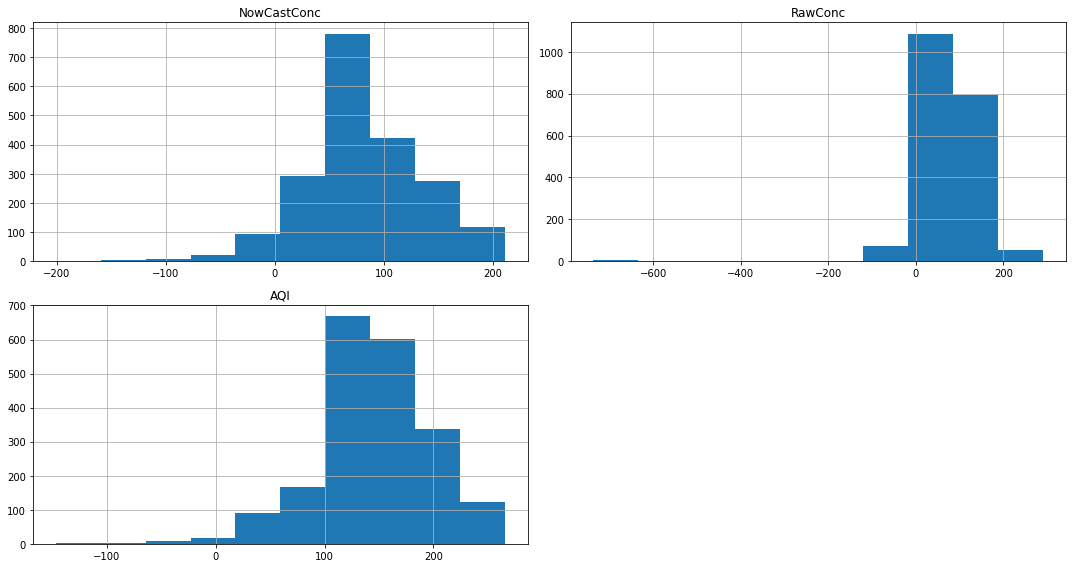

Skewness :
 NowCastConc   -0.189926
RawConc       -4.175744
AQI           -0.619782
dtype: float64


<Figure size 1080x576 with 0 Axes>

In [ ]:
# Check the distribution of the all numerical columns and print skewness of the data :

AQI_df.drop(['Hour', 'Date'], axis=1).hist()
plt.tight_layout()
plt.title("Distribution of Data")
plt.show()
plt.savefig('Distribution of data.png')
# Print the skewness of the data :
print('Skewness :\n', AQI_df.drop(['Hour', 'Date'], axis=1).skew())

The impact of  NowCastConc on AQI


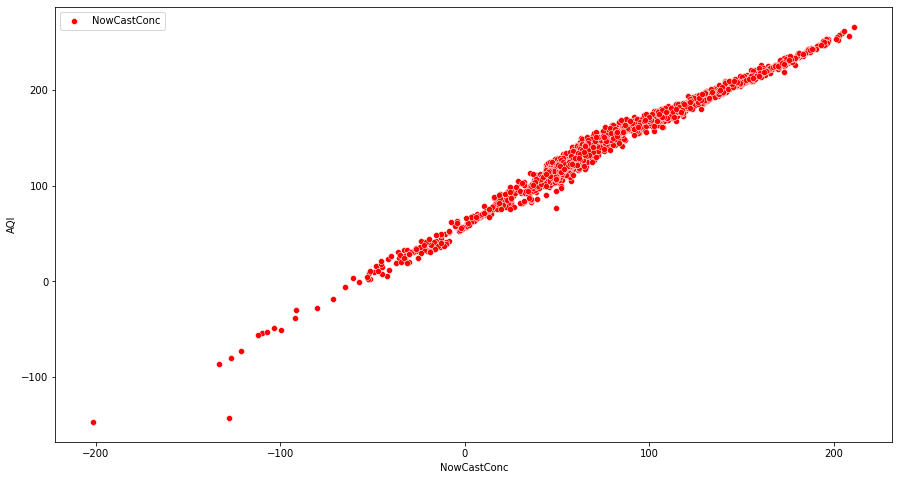

The impact of  RawConc on AQI


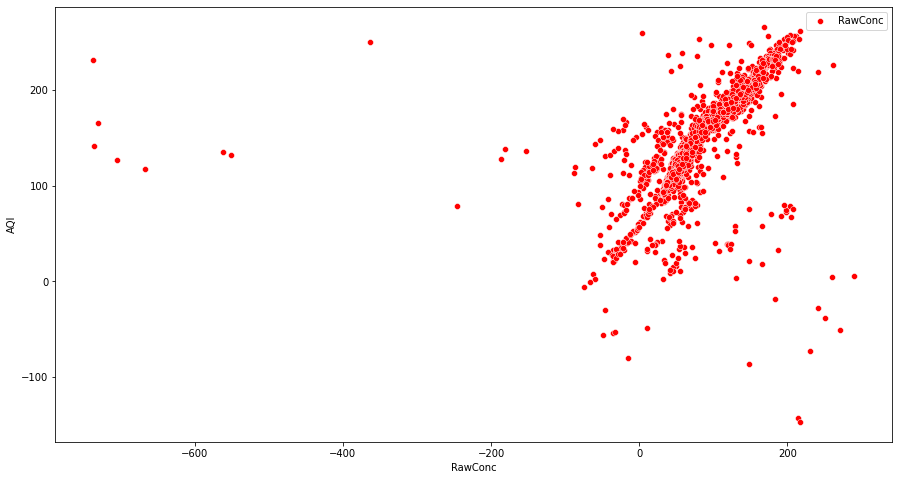

The impact of  AQI on AQI


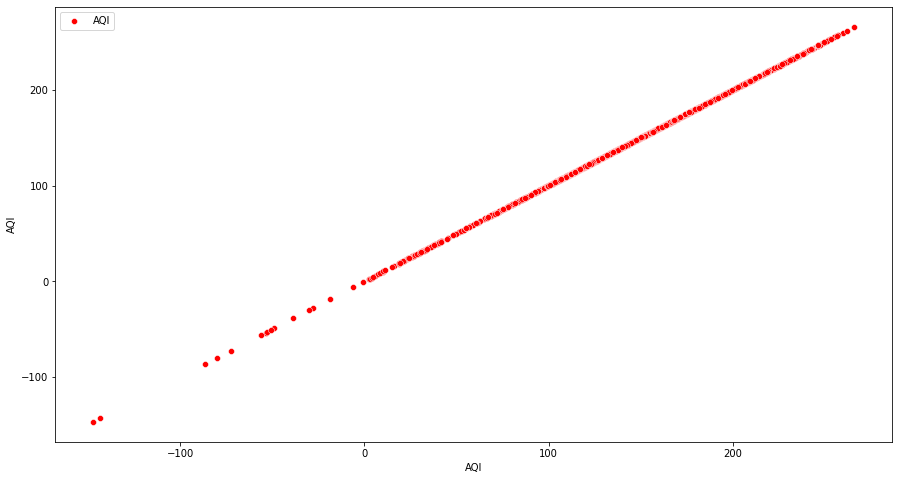

In [ ]:
# Check the effect of all pollutants on AQI :

for i in AQI_df.iloc[:, 2:13]:
    print('The impact of ', i, 'on AQI')
    sns.scatterplot(x = i, y ='AQI', data = AQI_df,marker="o",sizes=200,color="r",label=i)
    plt.legend()
    plt.show()

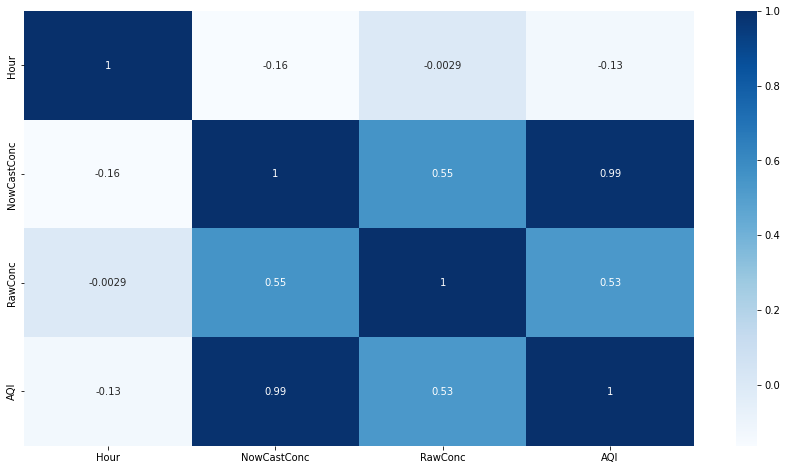

In [ ]:
# Correlation of the numerical data with heatmap :

sns.heatmap(AQI_df.corr(), annot=True, cmap='Blues')
plt.show()

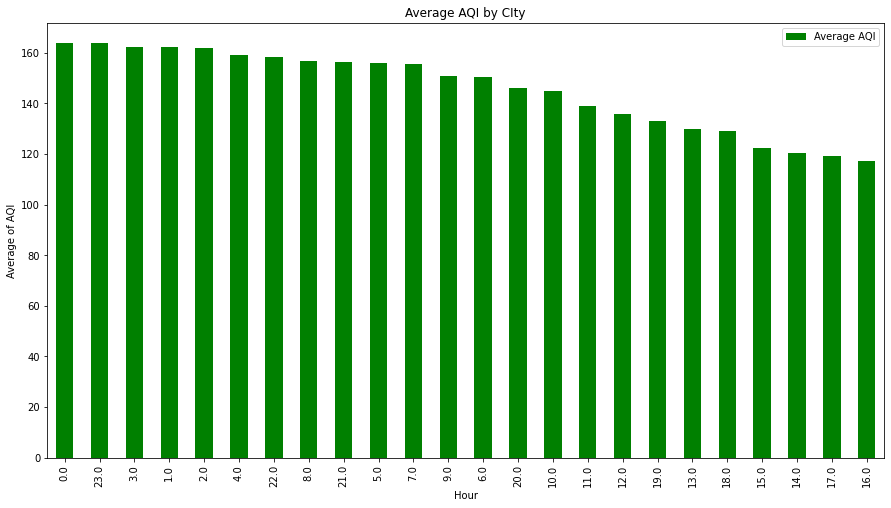

In [ ]:
# Check the Hourwise average of AQI :

AQI_df.groupby('Hour')['AQI'].mean().sort_values(ascending=False).plot(kind='bar',color="g",label="Average AQI")
plt.ylabel('Average of AQI')
plt.title("Average AQI by Hour")
plt.legend()
plt.show()

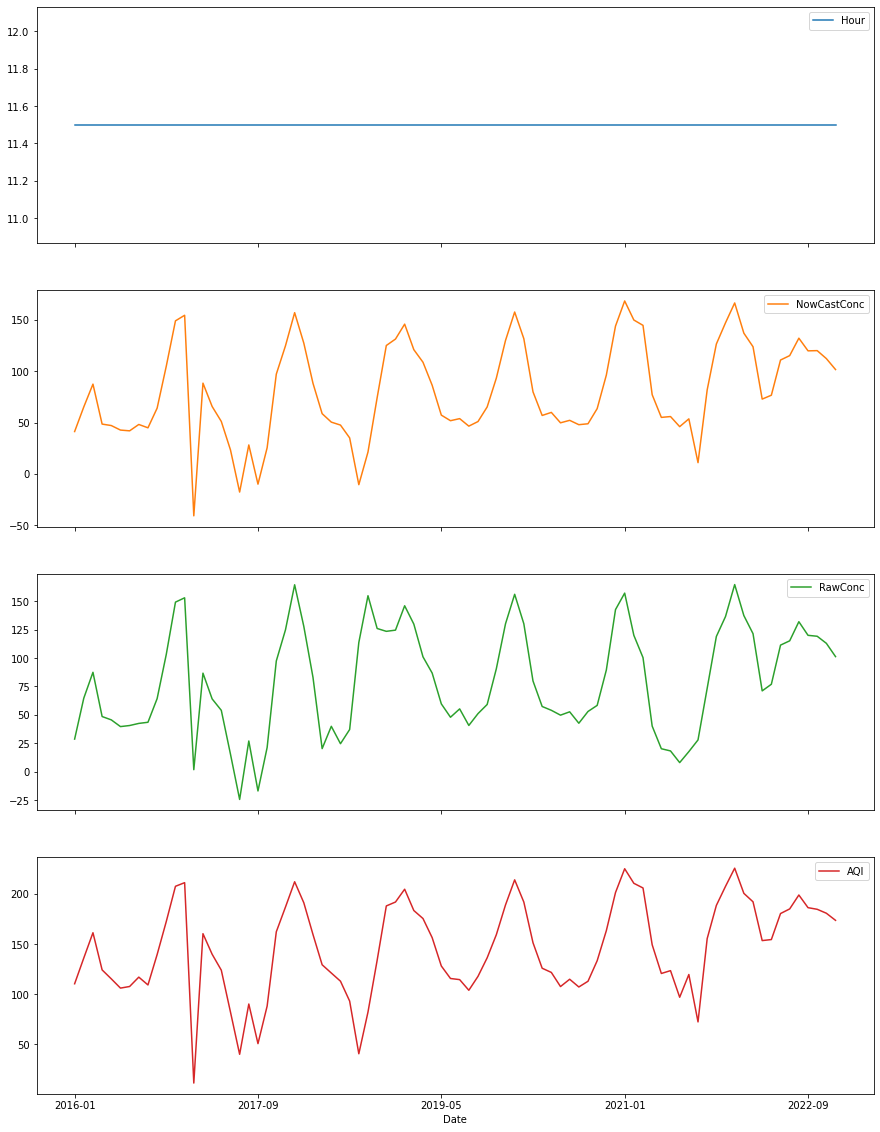

In [ ]:
# Yearly and Monthly Visualisation.

AQI_df.groupby(['Date']).mean().plot(kind='line', figsize=(15,20), subplots=True)

plt.show()

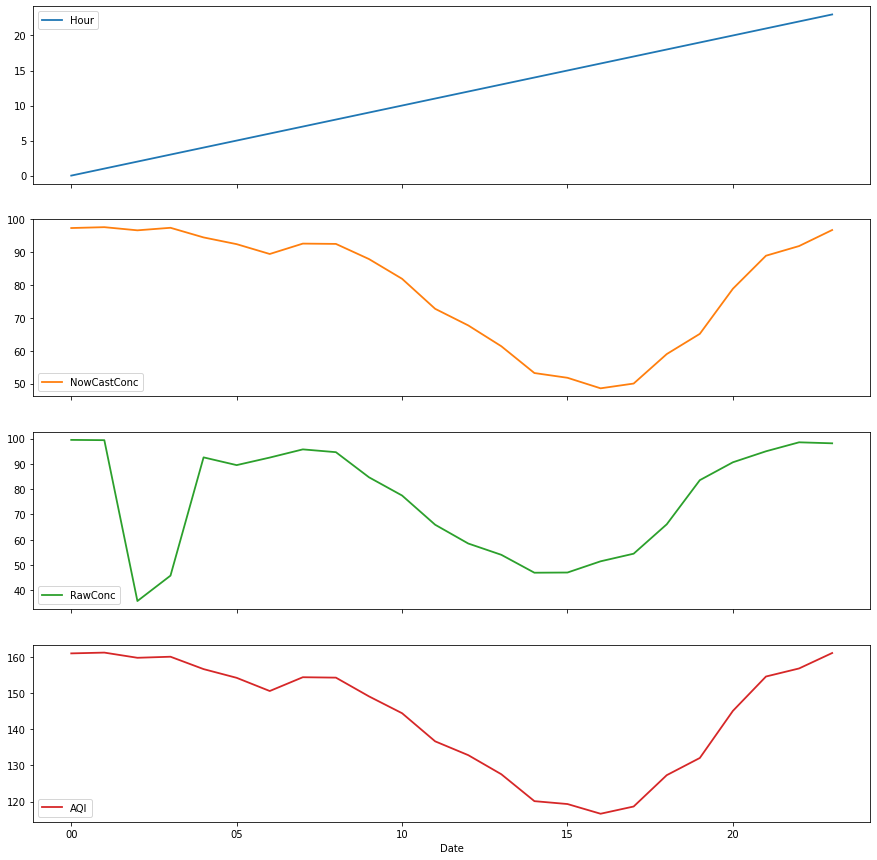

In [ ]:
# Hourly Visualisations

data_fill.groupby(data_fill.Date.dt.strftime('%H')).mean().plot(kind='line', figsize=(15,15), subplots=True,linewidth=1.8)
plt.show()

In [ ]:
# First seperate target and independent variables :
X = AQI_df.drop(['Hour', 'Date', 'AQI'], axis=1)
X = sm.add_constant(X)
y = AQI_df.AQI

# Fitting the model
model = OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AQI   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 4.765e+04
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:10:07   Log-Likelihood:                -6942.5
No. Observations:                2016   AIC:                         1.389e+04
Df Residuals:                    2013   BIC:                         1.391e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          66.7265      0.312    213.728      0.000      66.114      67.339
NowCastConc     0.9969      0.004    261.105      0.000       0.989       1.004
RawConc        -0.0209      0.003     -7.382      0.000      -0.026      -0.015
==============================================================================
Omnibus:                      311.888   Durbin-Watson:                   1.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2512.524
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                       8.385   Cond. No.                         255.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Print significant variables which are most affect on AQI :

significant = model.pvalues[model.pvalues < 0.05].sort_values(ascending=True)

print('Significant vaeiables which more affect on AQI :\n', significant)

Significant vaeiables which more affect on AQI :
 const          0.000000e+00
NowCastConc    0.000000e+00
RawConc        2.271582e-13
dtype: float64


In [ ]:
# Import the library :
from statsmodels.tsa.stattools import adfuller

# Perform the test :
adfuller(AQI_df.AQI)

(-6.760481829657498,
 2.8004865006782805e-09,
 26,
 1989,
 {'1%': -3.4336419856688276,
  '5%': -2.862994217611322,
  '10%': -2.567544164035933},
 20051.47477312603)

In [ ]:
# Before this, Convert Datetime variable into Datetime data type in new dataframe AQI_df :

AQI_df['Date'] = AQI_df['Date'].apply(pd.to_datetime)

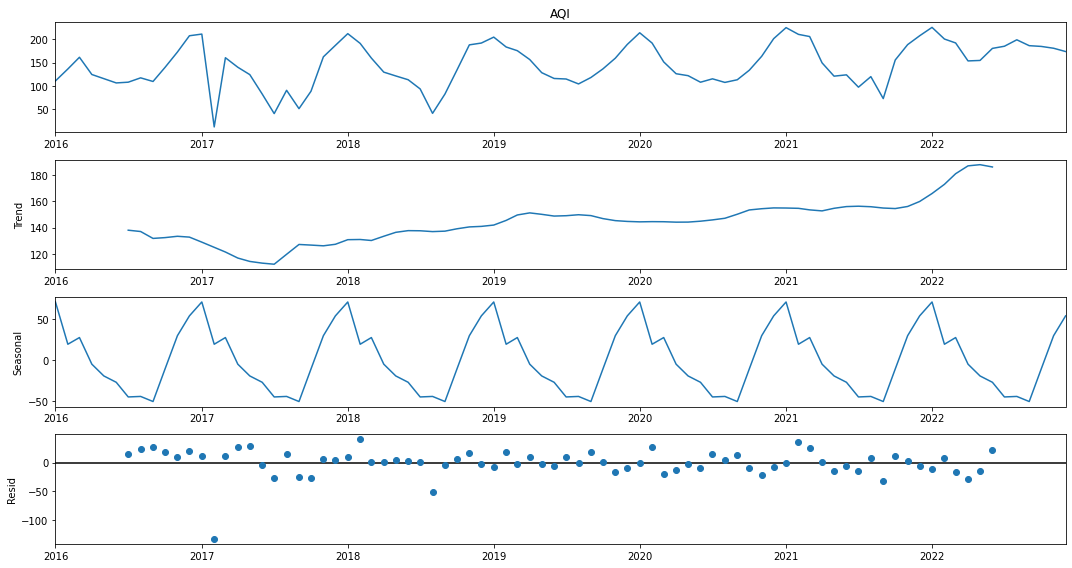

In [ ]:
# Remove city from the dataframe as it is a Categorical column :
df = AQI_df.drop('Hour', axis=1)

# Set Datetime as index :
df.set_index('Date', inplace=True)

# Do groupby Datetime for average of AQI :
df1 = df.groupby('Date')['AQI'].mean()

# Decompose the time series :
decomposition = sm.tsa.seasonal_decompose(df1, model='additive')
fig = decomposition.plot()
plt.show()

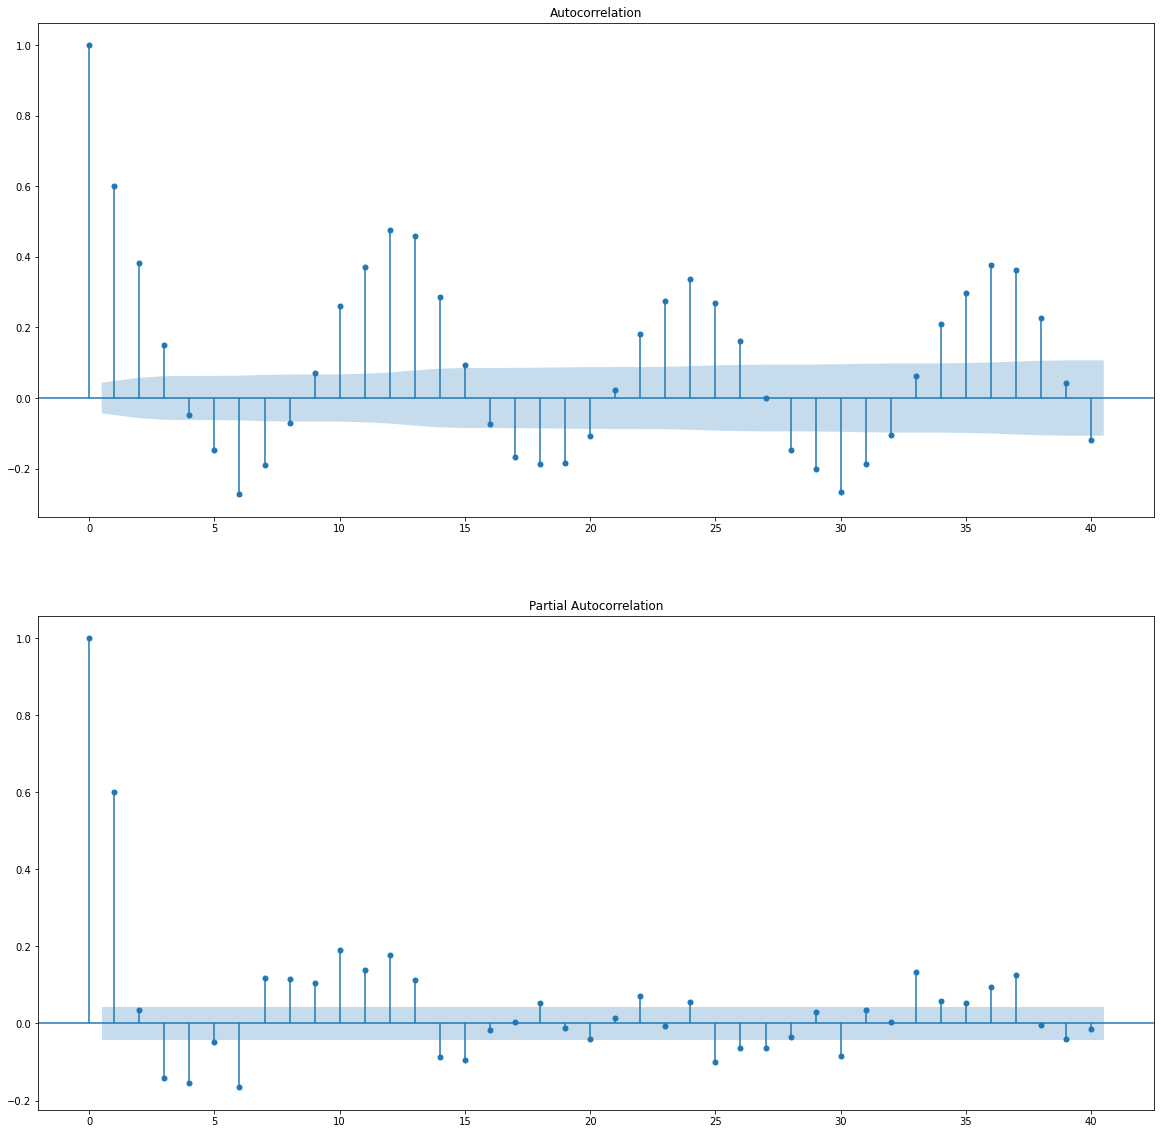

In [ ]:
# Import library ACF and PACF :
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# PLot :
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(df.AQI,lags=40,ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.AQI,lags=40,ax=ax2)
plt.show()

In [ ]:
# Defining Function for Accuracy metrics
def forecast_accuracy(forecast, actual):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    mape = np.mean(np.abs((actual - forecast)/actual))*100  # MAPE
    rmse = np.sqrt(mean_squared_error(actual,forecast))  # RMSE
    return({'mape':mape, 'rmse':rmse})

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def VAR_accuracy(predicted, valid):
    from sklearn.metrics import mean_squared_error
    for i in df.columns:
        print("rmse value for ",i,"is :' ",np.sqrt(mean_squared_error(valid[i], predicted[i])))
        print("mape value for ",i,"is :' ", MAPE(valid[i].values,predicted[i]), end = '\n\n')

In [ ]:
def VAR_AQI_MAPE(predicted, valid):
    return (MAPE(valid['AQI'].values,predicted['AQI']))
    

In [ ]:
def VAR_AQI_RMSE(predicted, valid):
    return (np.sqrt(mean_squared_error(valid['AQI'], predicted['AQI'])))

In [ ]:
#Month Wise Analysis
# Prepare the data for Analysis :   (Purpose to make simple data for Time series)

month = data_fill.groupby([pd.Grouper(key='Date', freq='m')]).mean()

# Reset Index
month = month.reset_index()

# Setting Index
month = month.set_index('Date')

# Dropping the categorical
#week = week.drop('Hour', axis = 1)

# Check the dimensions of the data :
print(month.shape)

month.head()

(84, 4)


,Hour,NowCastConc,RawConc,AQI
Date,,,,
2016-01-31,11.632911,41.077637,28.721519,110.227848
2016-02-29,11.500000,65.218333,64.595833,136.062500
2016-03-31,11.501437,87.409052,87.347701,161.254310
2016-04-30,11.500000,48.494792,48.415179,124.200893
2016-05-31,11.500000,47.074713,45.482759,115.287356


In [ ]:
#Base Model - ARIMA
#creating Train test split
train_month=month[:int(0.8*(len(month)))]
print('Train shape', train_month.shape)

valid_month=month[int(0.8*(len(month))):]
print('Test shape', valid_month.shape)

Train shape (67, 4)
Test shape (17, 4)


In [ ]:
# Fitting the model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_month.AQI,  order=(1,1,1)) 
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                   67
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -339.268
Date:                Mon, 27 Feb 2023   AIC                            684.536
Time:                        17:10:10   BIC                            691.105
Sample:                    01-31-2016   HQIC                           687.131
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2013      1.565     -0.129      0.898      -3.268       2.865
ma.L1          0.0754      1.577      0.048      0.962      -3.015       3.166
sigma2      1707.3718    180.116      9.479      0.000    1354.352    2060.392
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               154.89
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
#Auto - ARIMA (Month wise - Univariate)
# Import the library:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train_month.AQI, trace = True, suppress_warnings = True, seasonal = False)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=699.668, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=859.713, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=694.550, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=795.908, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=695.777, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=695.810, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=697.737, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=680.817, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=707.853, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=682.329, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=682.542, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=687.639, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=677.269, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=675.804, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=680.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -331.902
Date:                Mon, 27 Feb 2023   AIC                            675.804
Time:                        17:10:22   BIC                            689.033
Sample:                    01-31-2016   HQIC                           681.039
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.1672     29.044      1.417      0.156     -15.758      98.093
ar.L1          1.2201      0.383      3.187      0.001       0.470       1.971
ar.L2         -0.2818      0.345     -0.817      0.414      -0.958       0.395
ar.L3         -0.2371      0.203     -1.169      0.242      -0.635       0.160
ma.L1         -0.7066      0.350     -2.017      0.044      -1.393      -0.020
sigma2      1157.6521    166.991      6.932      0.000     830.356    1484.948
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               224.31
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#SARIMAX Model ( Month wise - Univariate Analysis)
#To consider the seasonality in ARIMA model, we will build SARIMAX model on the basis of ARIMA order.
import statsmodels.api as sm
mod_month = sm.tsa.statespace.SARIMAX(train_month.AQI,
                                order=(3, 0, 2),
                                seasonal_order=(3, 0, 2, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
mod_month.initialize_approximate_diffuse()
result_month = mod_month.fit()
result_month.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  method=method,


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                AQI   No. Observations:                   67
Model:             SARIMAX(3, 0, 2)x(3, 0, 2, 12)   Log Likelihood                -421.408
Date:                            Mon, 27 Feb 2023   AIC                            864.817
Time:                                    17:10:30   BIC                            889.068
Sample:                                01-31-2016   HQIC                           874.413
                                     - 07-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1428      0.316      3.620      0.000       0.524       1.762
ar.L2         -0.0428      0.353     -0.121      0.904      -0.734       0.649
ar.L3         -0.1027      0.265     -0.387      0.699      -0.623       0.417
ma.L1         -0.1882     46.902     -0.004      0.997     -92.114      91.738
ma.L2         -0.8107     38.088     -0.021      0.983     -75.463      73.841
ar.S.L12       0.6147      0.156      3.948      0.000       0.310       0.920
ar.S.L24       0.4011      0.113      3.557      0.000       0.180       0.622
ar.S.L36      -0.0238      0.084     -0.284      0.776      -0.188       0.141
ma.S.L12      -0.3958      9.472     -0.042      0.967     -18.960      18.169
ma.S.L24      -0.5461      6.517     -0.084      0.933     -13.319      12.227
sigma2       144.4154   6891.016      0.021      0.983   -1.34e+04    1.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.45
Prob(Q):                              0.82   Prob(JB):                         0.01
Heteroskedasticity (H):             231.72   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

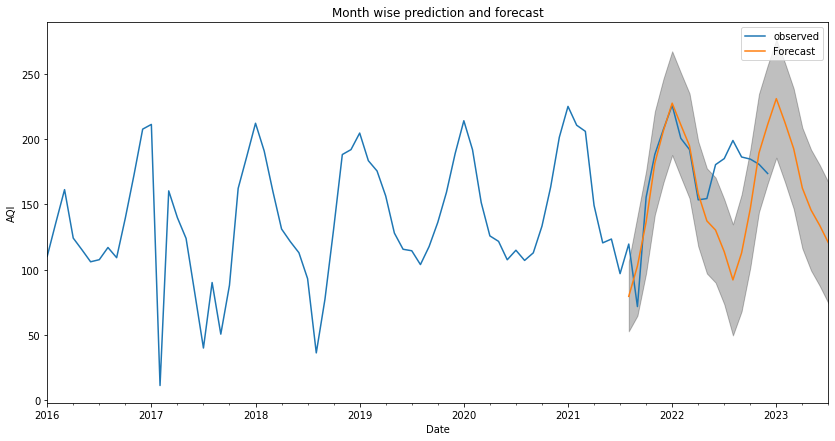

In [ ]:
#On the basis of SARIMAX result we will plot the predicted values of valid set as well as future values of AQI for 2023.
## Forecast for valid set and Future

pred_uc_month = result_month.get_forecast(steps=24)
pred_ci = pred_uc_month.conf_int()
ax = month.AQI.plot(label='observed', figsize=(14, 7))
pred_uc_month.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.title("Month wise prediction and forecast")
plt.legend()
plt.show()

In [ ]:
# Calculate Accuracy Metrics

forecast_accuracy(pred_uc_month.predicted_mean[:17], valid_month.AQI)

{'mape': 18.854871085629306, 'rmse': 42.459162824380655}

In [ ]:
print(train_month.columns)

Index(['Hour', 'NowCastConc', 'RawConc', 'AQI'], dtype='object')


In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Fitting the VAR model
VAR_model_month=VAR(endog=train_month)
VAR_model_month_fit=VAR_model_month.fit()



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [ ]:
valid_month.columns


Index(['Hour', 'NowCastConc', 'RawConc', 'AQI'], dtype='object')

In [ ]:
print(df.columns)

Index(['NowCastConc', 'RawConc', 'AQI'], dtype='object')


In [ ]:
# Predicting on Validation set
predict_month=VAR_model_month_fit.forecast(VAR_model_month_fit.y,steps=len(valid_month))

pred_month=pd.DataFrame(predict_month,columns=valid_month.columns,index=range(0,len(predict_month)))

In [ ]:
VAR_accuracy(pred_month, valid_month)

rmse value for  NowCastConc is :'  48.534930754262035
mape value for  NowCastConc is :'  54.17533635210111

rmse value for  RawConc is :'  44.88712736613727
mape value for  RawConc is :'  38.93510889551743

rmse value for  AQI is :'  50.05852224599972
mape value for  AQI is :'  26.53024876459834



In [ ]:
VAR_AQI_MAPE(pred_month, valid_month)

26.53024876459834

In [ ]:
VAR_AQI_RMSE(pred_month, valid_month)


50.05852224599972

In [ ]:

# Prepare the data for Analysis :   (Purpose to make simple data for Time series)

week = data_fill.groupby([pd.Grouper(key='Date', freq='w')]).mean()
week = week.fillna(method='ffill')
# Reset Index
week = week.reset_index()

# Setting Index
week = week.set_index('Date')

# Dropping the categorical
week = week.drop('Hour', axis = 1)

# Check the dimensions of the data :
print(week.shape)

# Check first five values
week.head(10)

(363, 3)


,NowCastConc,RawConc,AQI
Date,,,
2016-01-03,187.900000,188.523810,242.809524
2016-01-10,12.308929,-5.250000,81.452381
2016-01-17,77.533333,77.708333,152.937500
2016-01-24,77.533333,77.708333,152.937500
2016-01-31,77.533333,77.708333,152.937500
2016-02-07,76.254167,74.666667,148.266667
2016-02-14,54.182500,54.525000,123.858333
2016-02-21,54.182500,54.525000,123.858333
2016-02-28,54.182500,54.525000,123.858333


In [ ]:
#creating Train test split
train_week=week[:int(0.8*(len(week)))]
print('Train shape', train_week.shape)

valid_week=week[int(0.8*(len(week))):]
print('Test shape', valid_week.shape)

Train shape (290, 3)
Test shape (73, 3)


In [ ]:
#Auto ARIMA on week wise data
from pmdarima import auto_arima

stepwise_fit_week = auto_arima(train_week.AQI, trace = True, suppress_warnings = True, seasonal = False)

stepwise_fit_week.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3731.507, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3905.783, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3781.994, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3809.752, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3731.616, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3785.687, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3662.431, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3694.852, Time=0.23 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=3660.269, Time=0.34 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3661.743, Time=0.24 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=3659.383, Time=0.54 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=3662.709, Time=0.35 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=3660.616, Time=0.84 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=3659.277, Time=0.43 sec
 ARIMA(3,0,3)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  290
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -1815.203
Date:                Mon, 27 Feb 2023   AIC                           3648.407
Time:                        17:11:08   BIC                           3681.436
Sample:                    01-03-2016   HQIC                          3661.640
                         - 07-18-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     38.3645     10.403      3.688      0.000      17.975      58.754
ar.L1          1.0028      0.060     16.681      0.000       0.885       1.121
ar.L2         -0.8783      0.069    -12.818      0.000      -1.013      -0.744
ar.L3          0.5667      0.037     15.304      0.000       0.494       0.639
ma.L1         -0.7357      0.075     -9.821      0.000      -0.883      -0.589
ma.L2          0.5926      0.048     12.395      0.000       0.499       0.686
ma.L3         -0.2079      0.064     -3.253      0.001      -0.333      -0.083
ma.L4          0.2377      0.051      4.698      0.000       0.139       0.337
sigma2      1.554e+04    498.702     31.163      0.000    1.46e+04    1.65e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9653.98
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -3.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#SARIMAX Model ( Week wise - Univariate Analysis)
#To consider the seasonality in ARIMA model, we will build SARIMAX model on the basis of ARIMA order.
mod_week = sm.tsa.statespace.SARIMAX(train_week.AQI,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
mod_week.initialize_approximate_diffuse()
result_week = mod_week.fit()
result_week.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 AQI   No. Observations:                  290
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1611.429
Date:                             Mon, 27 Feb 2023   AIC                           3230.857
Time:                                     17:11:31   BIC                           3244.730
Sample:                                 01-03-2016   HQIC                          3236.449
                                      - 07-18-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1884      0.045      4.229      0.000       0.101       0.276
ma.L1         -0.8692      0.025    -34.165      0.000      -0.919      -0.819
ar.S.L52      -0.1935      0.030     -6.476      0.000      -0.252      -0.135
sigma2      4.442e+04   2111.298     21.039      0.000    4.03e+04    4.86e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              1125.03
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

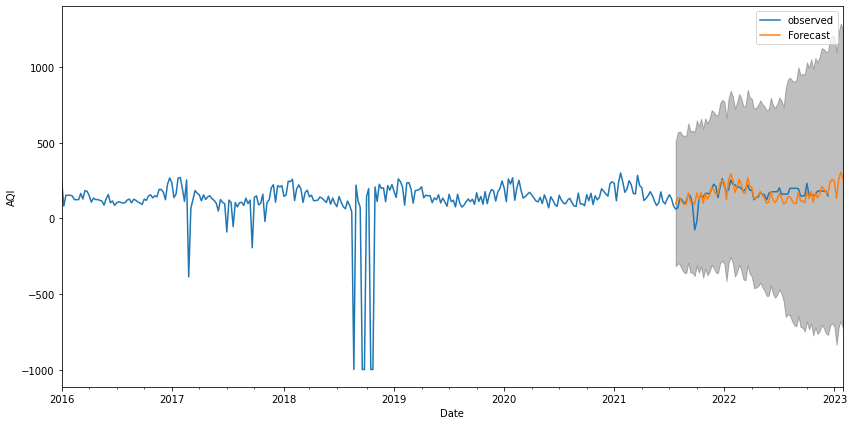

In [ ]:
## Forecast for valid set and Future

pred_uc_week = result_week.get_forecast(steps=80)
pred_ci = pred_uc_week.conf_int()
ax = week.AQI.plot(label='observed', figsize=(14, 7))
pred_uc_week.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
# Calculate Accuracy Metrics

forecast_accuracy(pred_uc_week.predicted_mean[:len(valid_week.AQI)], valid_week.AQI)

{'mape': 34.67481940945358, 'rmse': 48.41605912124772}

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Fitting the VAR model
VAR_model_week=VAR(endog=train_week)
VAR_model_week_fit=VAR_model_week.fit()

# Predicting on Validation set
predict_week=VAR_model_week_fit.forecast(VAR_model_week_fit.y,steps=len(valid_week))

pred_week=pd.DataFrame(predict_week,columns=df.columns,index=range(0,len(predict_week)))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [ ]:
VAR_accuracy(pred_week, valid_week)


rmse value for  NowCastConc is :'  64.8417471526232
mape value for  NowCastConc is :'  46.76746896135487

rmse value for  RawConc is :'  60.306233159617676
mape value for  RawConc is :'  2956.265829322958

rmse value for  AQI is :'  67.31804763909018
mape value for  AQI is :'  42.932065032034885



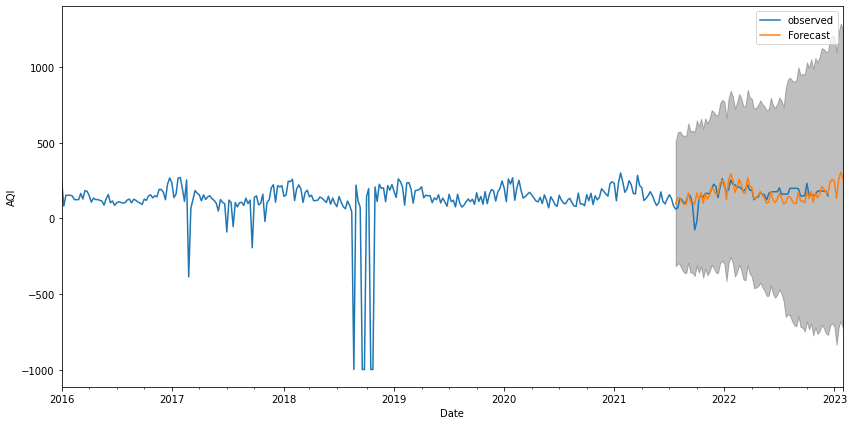

In [ ]:
## Forecast for valid set and Future

pred_uc_week = result_week.get_forecast(steps=80)
pred_ci = pred_uc_week.conf_int()
ax = week.AQI.plot(label='observed', figsize=(14, 7))
pred_uc_week.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

# Comparative Analysis

In [ ]:
res=[["SARIMAX Month wise",(forecast_accuracy(pred_uc_month.predicted_mean[:17], valid_month.AQI)['rmse']),forecast_accuracy(pred_uc_month.predicted_mean[:17], valid_month.AQI)['mape']],
     ["VAR MONTH Wise",(VAR_AQI_RMSE(pred_month, valid_month)),VAR_AQI_MAPE(pred_month, valid_month)],
["SARIMAX Week Wise",(forecast_accuracy(pred_uc_week.predicted_mean[:len(valid_week.AQI)], valid_week.AQI)['rmse']),forecast_accuracy(pred_uc_week.predicted_mean[:len(valid_week.AQI)], valid_week.AQI)['mape']],
    ["VAR week Wise",(VAR_AQI_RMSE(pred_week, valid_week)),VAR_AQI_MAPE(pred_week, valid_week)]]

In [ ]:
results=pd.DataFrame(res,columns=["Model_Name","RMSE","MAPE"])


In [ ]:
results


,Model_Name,RMSE,MAPE
0,SARIMAX Month wise,42.459163,18.854871
1,VAR MONTH Wise,50.058522,26.530249
2,SARIMAX Week Wise,48.416059,34.674819
3,VAR week Wise,67.318048,42.932065
